Author: Arend-Jan Quist\
Date created: 26 November 2021\
Last modified: 11 February 2022

In this program, the post-processing on the output phase vectors of the c-sieve is simulated.
The multipliers of the output phase vector from the c-sieve are assumed to be binomial distributed with parameters $n=L-1$ and $p=\frac{1}{S}$ or are imported from a c-sieve simulator.\

To use imported phase vectors from the c-sieve simulator, run the program "Save_phasevectors_c-sieve-simulator.ipynb".


In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [2]:
# This function can be replaced by importing a phase vector (its multipliers) from a c-sieve simulation
def create_multipliers(n,p,S):
    """Create multipliers as simulation for a c-sieve output vector according to the binomial distribution""" 
    
    multipliers = np.random.binomial(n,p,S)# create random multipliers

    L_updated = np.sum(multipliers) # calculate length of obtained phase vector
    
    return (multipliers,L_updated)


def measure_counter_register(S,L,multipliers):
    """Find random output of measurement of first register of |I(j)> 's""" 
    
    x = np.random.randint(L)

    for i in range(S):
        res = x - multipliers[i]
        if (res >= 0):
            x = res
        else:
            break
    I_measured = x
    return I_measured


def create_punctured_phasevector(multipliers,I_measured):
    """Create the punctured phase vector based on the multipliers of the 
    original phase vector and the measured value of the counter register.
    """
    X = [multipliers>I_measured] 
    X_card = np.sum(X) # number of surviving indices
    X = np.nonzero(X[0])[0] # set of surviving indices
    return (X,X_card)

@jit(nopython=True)
def calculate_probability(S,X,X_card,theta):
    _sum = 0
    for b in X:
        #print(b)
        _sum += np.exp(2j*np.pi*b*theta)
    return abs(_sum)**2 / (X_card*S)


def calculate_probabilities(S,X,X_card,range_theta):
    probabilities = []
    
    for theta in range_theta:
        probabilities.append(calculate_probability(S,X,X_card, theta))
    return probabilities


def simulate(L,S,seed=20211126):
    """Simulate the post processing of option (1) averaged over measurements
    """
    
    np.random.seed(seed) # set seed to make things reproducible
    
    # parameters for random multipliers
    n = L-1
    p = 1/S
    
    # create phase vector as from c-sieve
    multipliers,L = create_multipliers(n,p,S)
    
    
    # apply post processing: first measure counter register, than measure the other register.
    
    n_q = 1  # number of values of q sampled
    range_q = np.linspace(0,1/(2*S),n_q)
    
    N_measurements = 1000  # number of times the state is measured
    
    probabilities = np.zeros([N_measurements,n_q])
    
    for i in range(N_measurements):
        I_measured = measure_counter_register(S,L,multipliers)
        X,X_card = create_punctured_phasevector(multipliers,I_measured)
        
        for j,q in enumerate(range_q):
            probabilities[i][j] = sum(calculate_probabilities(S,X,X_card,[q]))#,1/S-q,1/S+q,2/S-q]))
            
    return probabilities

In [3]:
# parameters

L = 5000 # length of phase vector
S = 500 # range of phase vector
N = 1000000  # group order -> not needed in this simulation
    
# parameters for random multipliers
n = L-1
p = 1/S

np.random.seed(20211126) # set seed to make things reproducible

import_phasevector = True

In [4]:
if import_phasevector:
    # import phase vector from file
    i=0 #number of run
    r=2 #arity
    infile = "Phasevectors/phasevector_"+str(L)+"_"+str(S)+"_"+str(N)+"_"+str(r)+"_"+str(i)+".npz"
    data=np.load(infile,allow_pickle=True)['data']
    multiplier_values = data[0]
    multipliers = np.histogram(multiplier_values,np.arange(-0.5,S+1 +0.5))[0]
    L = data[1]
    
else:
    # create phase vector as from c-sieve by simulation
    multipliers,L = create_multipliers(n,p,S)
    
print("L_realized =", L)
#multipliers[0]

L_realized = 1519


In [5]:
# Simulation of the post processing


# apply post processing: first measure counter register, than measure the other register.

n_q = 1  # number of values of q sampled
range_q = np.linspace(0,1/(2*S),n_q)

N_measurements = 1000  # number of times the state is measured

probabilities = np.zeros([N_measurements,n_q])

for i in range(N_measurements):
    I_measured = measure_counter_register(S,L,multipliers)
    X,X_card = create_punctured_phasevector(multipliers,I_measured)
    
    for j,q in enumerate(range_q):
        probabilities[i][j] = sum(calculate_probabilities(S,X,X_card,[q]))#,1/S-q,1/S+q,2/S-q]))
#print(np.average(probabilities,0))
#print(np.average(probabilities))

In [6]:

probabilities = []
range_L = np.logspace(5,18,30,base=2)
for L in range_L:
    probabilities.append(np.average(simulate(L,S)))
    

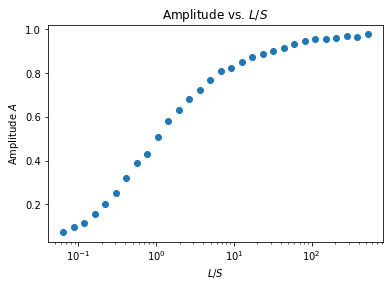

In [7]:
plt.plot(range_L[:]/S,probabilities[:],'o')
plt.semilogx()
#plt.semilogy()
plt.xlabel(r"$L/S$")
#plt.ylabel("Probability to find log(S) bits")
plt.ylabel(r"Amplitude $A$")
#plt.title(r"$q=θ=0, S=500$")
plt.title(r"Amplitude vs. $L/S$")

plt.savefig("Probability_vs_L_over_S_plot.pdf")
plt.show()

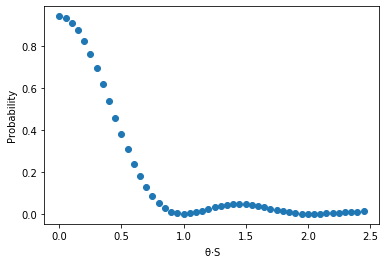

In [8]:
delta = 0.05

_range = np.arange(0,2.5/S,delta/S)
probabilities = []

for theta in _range:
    probabilities.append(calculate_probability(S,X,X_card, theta))
    #print(theta,"done.")
    
plt.plot(_range*S,probabilities,'o')
plt.xlabel(' θ$\cdot$S ')
plt.ylabel("Probability")
plt.show()

In [9]:
"""

# add random values of theta to the probability calculation to verify
# the continuity of the function

m = 50  # number of added uniform values of theta
rnd_thetas = np.random.uniform(0,2.5/S,m)
    
delta = 0.05

_range = np.arange(0,2.5/S,delta/S)
_range = np.append(_range,rnd_thetas)
probabilities = []

for theta in _range:
    probabilities.append(calculate_probability(S,X,X_card, theta))
    #print(theta,"done.")
    
plt.plot(_range*S,probabilities,'.')
plt.xlabel(' θ$\cdot$S ')
plt.ylabel("Probability")
plt.show()

"""

'\n\n# add random values of theta to the probability calculation to verify\n# the continuity of the function\n\nm = 50  # number of added uniform values of theta\nrnd_thetas = np.random.uniform(0,2.5/S,m)\n    \ndelta = 0.05\n\n_range = np.arange(0,2.5/S,delta/S)\n_range = np.append(_range,rnd_thetas)\nprobabilities = []\n\nfor theta in _range:\n    probabilities.append(calculate_probability(S,X,X_card, theta))\n    #print(theta,"done.")\n    \nplt.plot(_range*S,probabilities,\'.\')\nplt.xlabel(\' θ$\\cdot$S \')\nplt.ylabel("Probability")\nplt.show()\n\n'

Define $q=\left|\frac{s}{N}S - \left\lceil\frac{s}{N}S\right\rfloor\right|$. 

In [10]:
"""

print("Probability to learn log(S) resp. log(S)-1 bits of s\n")

for q in np.arange(0,0.5/delta+1,0.05/delta):
    print("q = ",np.round(q*delta,3),"\t",
          probabilities[int(q)],"\t",
          probabilities[int(q)]
          + probabilities[int(1/delta - q)] 
          + probabilities[int(1/delta + q)] 
          + probabilities[int(2/delta - q)]
         )
    plt.plot(np.round(q*delta,3),probabilities[int(q)],'bo')
    plt.plot(np.round(q*delta,3),
             probabilities[int(q)]
             + probabilities[int(1/delta - q)] 
             + probabilities[int(1/delta + q)]
             + probabilities[int(2/delta - q)],'ro')
             
"""

'\n\nprint("Probability to learn log(S) resp. log(S)-1 bits of s\n")\n\nfor q in np.arange(0,0.5/delta+1,0.05/delta):\n    print("q = ",np.round(q*delta,3),"\t",\n          probabilities[int(q)],"\t",\n          probabilities[int(q)]\n          + probabilities[int(1/delta - q)] \n          + probabilities[int(1/delta + q)] \n          + probabilities[int(2/delta - q)]\n         )\n    plt.plot(np.round(q*delta,3),probabilities[int(q)],\'bo\')\n    plt.plot(np.round(q*delta,3),\n             probabilities[int(q)]\n             + probabilities[int(1/delta - q)] \n             + probabilities[int(1/delta + q)]\n             + probabilities[int(2/delta - q)],\'ro\')\n             \n'

In [11]:
from scipy.optimize import curve_fit

def sinc(x, A, a):
    return A*np.sinc(a*x)**2
    #pi = np.pi
    #return (A*np.sin(a*pi*x)/(a*pi*x))**2

Fit parameters: [0.94376332 0.99976372]
Probability[0]: 0.944


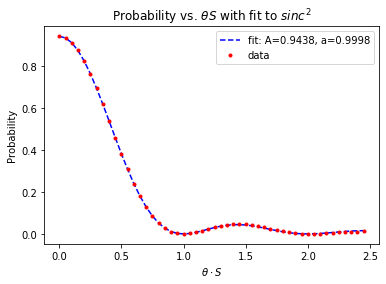

In [12]:
# fit sinc function to probability vs theta plot

xdata=_range*S
ydata=probabilities

popt, pcov = curve_fit(sinc, xdata, ydata,bounds=[0,[2,5]])
print("Fit parameters:",popt)
print("Probability[0]:",probabilities[0])
plt.plot(xdata, sinc(xdata, *popt), 'b--',
         label='fit: A=%5.4f, a=%5.4f' % tuple(popt))
#plt.plot(xdata, sinc(xdata, probabilities[0], 1), 'g--',
#         label='fit: A=probability(0), a=1')
plt.plot(xdata,ydata,'r.',label='data')
plt.xlabel(r"$\theta\cdot S$")
plt.ylabel("Probability")
#plt.title(r"Fit to $\frac{A \cdot \sin(\pi a x)}{\pi a x}$")
plt.title(r"Probability vs. $\theta S$ with fit to $sinc^2$")
plt.legend()

plt.savefig("Data_from_post-processing_simulator_with_sinc^2-fit.pdf")
plt.show()